# Text Classification for online clothing store reviews 

This project predicts the rating clasification of customer reviews for an e-commerce clothing. We used Naive Bayes and Natural Language Proccessing by creating a bag of words corpus to accomplish. The dataset used can be found on Kaggle's Women's E-commerce dataset.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

First we load the data set and take a small look at its contents, luckily this dataset is fairly organized and easy to understand at first glance

In [5]:
file = r'''C:\Users\Projects\datasets\Womensclothingreviews.csv'''
data = pd.read_csv(file)
data.head(2)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


Now we've decided what features we feel are most important to what we are trying to achieve, the text reviews(obviously), the ratings and whether binary recommendation.   

In [6]:
#generate new selected features data from dataset 
ndata = data[['Review Text','Rating','Recommended IND']]
ndata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,23486.0,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Recommended IND,23486.0,0.822362,0.382216,0.0,1.0,1.0,1.0,1.0


## Data Cleaning and some feature engineering 

We checked for ad removed rows with empty text reviews since that is the feature we are interested in. Then created a new feature for how long in words a review text is.

In [7]:
#check for empty text reviews and reduce features
emptyColumns = ndata.columns[ndata.isnull().any()]
ndata[emptyColumns].isnull().sum()
emptyReview = ndata[ndata["Review Text"].isnull()][emptyColumns]

TextData = ndata.drop(emptyReview.index) #data without empty text reviews  
TextData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 3 columns):
Review Text        22641 non-null object
Rating             22641 non-null int64
Recommended IND    22641 non-null int64
dtypes: int64(2), object(1)
memory usage: 707.5+ KB


In [8]:
#add new column text length of the reviews
TextData['textlength'] = TextData['Review Text'].apply(len)
TextData.head(10)

,Review Text,Rating,Recommended IND,textlength
0,Absolutely wonderful - silky and sexy and comf...,4,1,53
1,Love this dress! it's sooo pretty. i happene...,5,1,303
2,I had such high hopes for this dress and reall...,3,0,500
3,"I love, love, love this jumpsuit. it's fun, fl...",5,1,124
4,This shirt is very flattering to all due to th...,5,1,192
5,"I love tracy reese dresses, but this one is no...",2,0,488
6,I aded this in my basket at hte last mintue to...,5,1,496
7,"I ordered this in carbon for store pick up, an...",4,1,482
8,I love this dress. i usually get an xs but it ...,5,1,166
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,360


## Now for some visual analysis, basically graphs

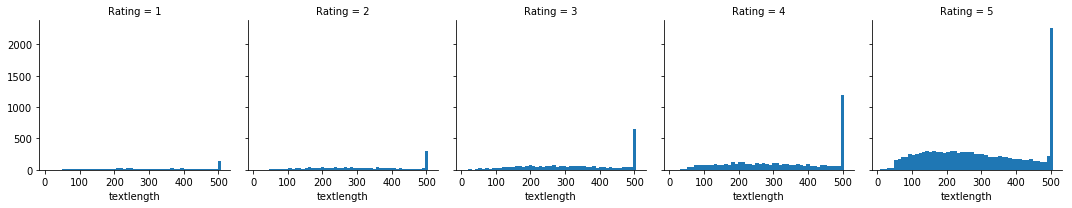

In [9]:
#Plot Visualizations 
#rating vs text length distribution 
pt1 = sns.FacetGrid(data=TextData, col='Rating')
pt1.map(plt.hist, 'textlength', bins=50)
plt.show(pt1)

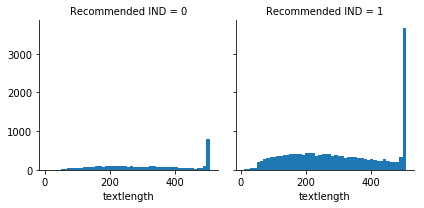

In [10]:
#Recommended vs text length distribution
pt2 = sns.FacetGrid(data=TextData, col='Recommended IND')
pt2.map(plt.hist, 'textlength', bins=50)
plt.show(pt2)

We see that longer text lengths often occur with the highest ratings and when products are recommended.

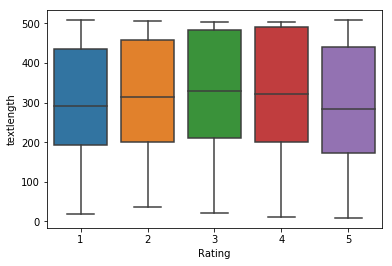

In [11]:
#rating vs text length distribution: Boxplot
pt3 = sns.boxplot(x='Rating', y='textlength', data=TextData)
plt.show(pt3)

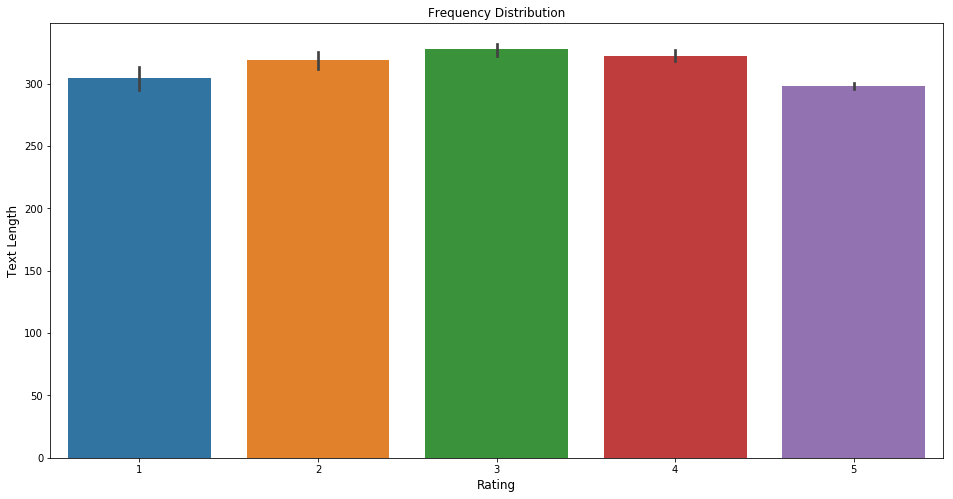

In [12]:
plt.subplots(figsize=(16, 8))
sns.barplot(x='Rating', y='textlength', data=TextData)
plt.title('Frequency Distribution')
plt.ylabel('Text Length', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.show()

The frequency distribution is fairly normal, that is expected. We then look into the textlength recommended correlation.

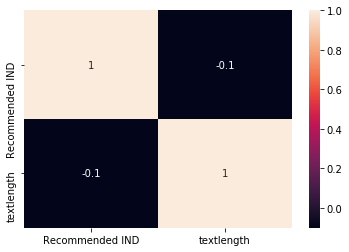

In [13]:
rel = TextData.groupby('Rating').mean()
rel.corr()
pt4 = sns.heatmap(data=rel.corr(), annot=True)
plt.show(pt4)

## Preprocessing
Now we process the data we need before modelling, this will include creating a corpus and vector count for those words.

In [15]:
#get variables for prediction for ratings 1 and 5
predict_data = TextData[(TextData['Rating']==1) | (TextData['Rating']==5)]

#get variables for prediction for Recommended
predict_data = TextData
predict_data.shape

x = predict_data['Review Text']
y = predict_data['Recommended IND']

In [16]:
samplereview = x.iat[8989]
samplereview

'The fit is quite strange on me as the tie is very high on the waist. this makes the jacket look odd and quite voluminous. i was very impressed with the fabric though but will have to return. i wish retailer would post what size is the model wearing. maybe she is wearing a larger size than usual which falls lower.'

### Bag of words corpus
Lets build a funtion to accomplish this

In [17]:
#get feature vector for the classification task and use bag of words for corpus
import nltk 
from nltk.corpus import stopwords
import string

def text_processing(text):
# Takes in a string of text, Removes all punctuation and stopwords    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]


In [18]:
#Test of the processing
sample = "The Long Night is nearly upon us!! Winter is Coming."
text_processing(sample)

['Long', 'Night', 'nearly', 'upon', 'us', 'Winter', 'Coming']

As you can see the function rightly breaks the sample text into seperate words and ignores the punctuations i.e '!!' and '.'. Now to convert the all the words from a review to vector.

In [19]:
#Using CountVectorizer to change text to vectors as a 2d matrix[column=reviewText, rows= uniqueWords]
#BagOfWordsMatrix

import sklearn
from sklearn.feature_extraction.text import CountVectorizer  

BOfW = CountVectorizer(analyzer = text_processing).fit(x)
len(BOfW.vocabulary_)

19807

In [24]:
samplereview = x.iat[1999]
print('Sample Review:',samplereview)
samplebofw= BOfW.transform([samplereview])
print('\nSample Review Vectors:\n',samplebofw)

print('\nSome feature name from Bag of Words')
BOfW.get_feature_names()[8103]

Sample Review: Super cute, flattering design but the material is itchy so it's going back:(

Sample Review Vectors:
   (0, 1490)	1
  (0, 2586)	1
  (0, 5351)	1
  (0, 5704)	1
  (0, 7432)	1
  (0, 8103)	1
  (0, 9470)	1
  (0, 10869)	1

Some feature name from Bag of Words


'going'

These are the vector scores for words in the sample review above.

In [23]:
#transform x into sparse matrix
X = BOfW.transform(x)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)

# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Percentage Density of Non-Zero Values: ', density)

Shape of Sparse Matrix:  (22641, 19807)
Amount of Non-Zero occurrences:  616412
Percentage Density of Non-Zero Values:  0.13745380878750557


## Modelling
Using Naive Baiyes and precision & recall as metrics

In [25]:
#split data into Train and Test Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [26]:
#Train Model and Predict
from sklearn.naive_bayes import MultinomialNB
model= MultinomialNB().fit(X_train,y_train)
prediction = model.predict(X_test)

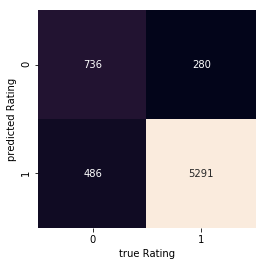

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cMatrix = confusion_matrix(y_test,prediction)
sns.heatmap(cMatrix.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true Rating')
plt.ylabel('predicted Rating');
plt.show()

In [29]:
print(classification_report(y_test,prediction))

             precision    recall  f1-score   support

          0       0.72      0.60      0.66      1222
          1       0.92      0.95      0.93      5571

avg / total       0.88      0.89      0.88      6793



And that concludes this project. '')